# Fast Fourier Transform

In the early 19th century Joseph Fourier introduced the radical idea that any periodic function—no matter how irregular—could be expressed as a sum of simple sine and cosine waves. This assertion opened an entirely new way of thinking: functions could be decomposed into fundamental frequency components, much like a prism decomposes light into colors.

Fourier's work (collectively known as Fourier Analysis, or Fourier Series, or Fourier Transforms) gave scientists and engineers a universal language for describing oscillations, waves, and signals. The notion of switching between time and frequency perspectives became indispensable in acoustics, optics, and electromagnetism. Today it underpins medical imaging, data compression, high fidelity audio, telecommunications, and photography -- to name a few diverse areas.

Equally important, Fourier’s ideas reshaped mathematics itself. The world could be understood in terms of frequencies. This insight transformed science and engineering and remains one of the most enduring legacies in the history of mathematics.

## The transform

The continuous Fourier transform of a function $f(t)$ is defined as

$$
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i\omega t}dt
$$

where $f(t)$ is the original function, $F(\omega)$ is the Fourier representation of $f$, $\omega$ is an invert quantity to $t$, and $i = \sqrt{-1}$. The transform can be used on any function $f$ but usually we look at functions in time and therefore, $\omega$ is a frequency.

The sines and cosines of the transform are "hidden" in $e^{-i\omega t}$. In the 1740s, Leonhard Euler showed that $e^{-i\theta} = \cos\theta - i\sin\theta$.

Of course no one wants to work with integrals. And besides, many signals that require Fourier analysis are discrete. So, given a sequence of $N$ values $[f_0, f_1, \ldots, f_{N-1}]$, their **discrete Fourier transform** is defined as

$$
F_k = \sum_{n=0}^{N-1} f_n\, e^{-2i\pi kn/N},\ \ \text{with}\ 0\leq k< N
$$

For simplicity, we assume that $f$ has real values -- we can deal with complex number later. In any case, the computation needs two nested loops as shown below.


In [1]:
import math


def dft(f: list[float]) -> list[float]:
    N: int = len(f)
    F: list = [0] * N
    for k in range(N):
        for n in range(N):
            F[k] += f[n] * math.cos(2 * math.pi * k * n / N)
    return F

Function `dft` performs in $\mathcal O (N^2)$ time, which is not terribly bad. We can do better, but it requires a bit of math work first.

## The case for a faster Fourier transform

Writing the sum for a Fourier component $F_k$:

\begin{align*}
F_k & = \sum_{n=0}^{N-1} f_n\, e^{-2i\pi kn/N} \\
      & = f_0 + f_1 e^{-2i\pi k/N} + f_2 e^{-2i\pi 2k/N} + f_3 e^{-2i\pi 3k/N} + f_4 e^{-2i\pi 4k/N} + \ldots
\end{align*}

we notice that there are even and odd-indexed terms, which can be grouped together:


\begin{align*}
 F_k  = &  \sum_{n=0}^{N-1} f_n\, e^{-2i\pi kn/N} \\ \\
         = & f_0 + f_2 e^{-2i\pi 2k/N} + f_4 e^{-2i\pi 4k/N} + \ldots +   \\
        & f_1 e^{-2i\pi k/N} +  f_3 e^{-2i\pi 3k/N} +  f_5 e^{-2i\pi 5k/N} +  \ldots \\ \\
         =& \sum_{m=0}^{N/2-1}  f_{2m} e^{-2i\pi(2m)k/N} + \sum_{m=0}^{N/2-1} f_{2m+1} e^{-2i\pi(2m+{\color{red}1})k/N} \\
         =&  \sum_{m=0}^{N/2-1}  f_{2m} e^{-2i\pi(2m)k/N} +{\color{red} e^{-2i\pi k/N}}\sum_{m=0}^{N/2-1} f_{2m+1} e^{-2i\pi(2m)k/N} \\
         =&E_k + e^{-2i\pi k/N} O_k
\end{align*}
where $E_k$ is the sum of even-indexed terms and $O_k$ the sum of odd-index terms. Because both sums are generated with the first $N/2$ indices,i.e., $0 \leq m < N/2$, the range of $k$ is also reduced to $0\leq k <N/2$.



The expression for $F_{k+\frac{N}{2}}$ can be derived directly from

$$
\sum_{m=0}^{N/2-1} x_m e^\frac{-i2\pi km}{N/2}
      + e^{-i2\pi k/N}\sum_{m=0}^{N/2-1} x_{2m+1} e^\frac{-i2\pi km}{N/2}
$$
by replacing $k$ with $k+\frac{N}{2}$ and remembering that $e^{-i\pi}=-1$ and $e^{-i2\pi m}=1$.

And so we have:

\begin{align*}
F_k & = E_k
      + e^{-i2\pi k/N}O_k\\
F_{k+\frac{N}{2}} & = E_k
      - e^{-i2\pi k/N}O_k
\end{align*}
with $k=0,1,\ldots,N/2-1$, where $E_k$ and $O_k$ are the left and right half-sums derived earlier.

What we achieved here is to take a problem of size $N$ and split it into two problems of size $N/2$. This is divide-and-conquer problem with recurrence $T(N) = 2T\left(N/2\right)+f(N)$. Based on the master theorem, $T(N)\in\mathcal{O}(N\log N)$.



## Implementing the FFT

Divide-and-conquer techniques are best implemented with recursion. Therefore we need a base case to end the recursive calls. Given a data set with $N$ elements, after $\log_2 N$ splits, we end up with $N$ single-element data sets. What's the DFT of a dataset with a single element? For such a set, $\color{green}N=1$ and


\begin{align*}
X_{k} & = \sum_{n=0}^{\color{green}N-1} x_n e^{-i2\pi kn/N},\ \ 0 \leq k < {\color{green}1} \\
      & =x_{\color{green}0} e^{\color{green}} = x_{\color{green}0}
\end{align*}

This is remarkable: the discrete fourier transform of a single data point **is the data point itself!** It is also the base case we were looking for, and we can now write the pseudocode for the FFT.

\begin{align*}
& \textbf{fft}(x): \\
& \quad \text{if}\ \text{len}(x) = 1: \\
& \quad\quad \text{return}\ x[0] \\
& \quad x_\text{even} = \text{even-indexed elements of } x \\
& \quad x_\text{odd} = \text{odd-indexed elements of } x \\
& \quad \text{EVEN}_k = \textbf{fft}(x_\text{even}) \\
& \quad \text{ODD}_k = e^{-i2\pi k/N}\textbf{fft}(x_\text{odd}) \\
& \quad \> \text{return}\ \text{EVEN}_k+\text{ODD}_k,\ k\in[0,N/2)\ \text{and} \\
& \qquad \qquad\text{EVEN}_k-\text{ODD}_k,\ k\in[N/2,N)
\end{align*}

# Your assignment

Python has built-in support for complex numbers. Which means that expressions like $e^{-i2\pi k/N}$ can be coded as
```python
cmath.exp(-2j * cmath.pi * k / N)
```
after importing the [`cmath`](https://docs.python.org/3/library/cmath.html) module. (It's ok to `import cmath` for this assignment).

Implement the FFT first as a recursive method and then as an iterative method. Use the following code to test both methods -- results should be comparable.

```python
import cmath

# --------- quick check ---------
if __name__ == "__main__":
    # small real signal
    f = [1, 2, 3, 4, 2, 0, 1, -1]
    F = fft(f)  # power-of-two length OK
    # print first few coefficients
    for k, v in enumerate(F):
        print(k, v)
```


# Reading

* **PDF:** [An algorithm for the machine calculation of complex Fourier series](https://www.ams.org/mcom/1965-19-090/S0025-5718-1965-0178586-1/S0025-5718-1965-0178586-1.pdf): the original paper on FFT by Cooley and Tukey.

* **PDF:** [The Design and Implementation of FFTW3](http://fftw.org/fftw-paper-ieee.pdf) discusses why faster algorithms some times slow down a bit.

* **PDF:** [FFT material](https://jeffe.cs.illinois.edu/teaching/algorithms/notes/A-fft.pdf) from Jeff Erickson's book. As much as I like Jeff's book, I think this chapter is a bit dense or scattered. With patience, you may find good information but it's not an easy read.

In [1]:
import cmath

def fft_recursive(x: list[complex]) -> list[complex]:
    N: int = len(x)
    F: list[complex] = [0] * N
    
    if N == 1:
        return x
    
    even_set: list[complex] = x[::2]
    odd_set: list[complex] = x[1::2]
    k_even: list[complex] = fft_recursive(even_set)
    k_odd_temp: list[complex] = fft_recursive(odd_set)
    
    k_odd: list[complex] = []
    for k in range(N//2):
        k_odd.append(cmath.exp(-2j * cmath.pi * k / N) * k_odd_temp[k])

    for k in range(N//2):
        F[k] = k_even[k] + k_odd[k]
        F[k + N//2] = k_even[k] - k_odd[k]
    return F
    

In [2]:
import cmath

# --------- quick check ---------
if __name__ == "__main__":
    # small real signal
    f = [1, 2, 3, 4, 2, 0, 1, -1]
    F = fft_recursive(f)  # power-of-two length OK
    # print first few coefficients
    for k, v in enumerate(F):
        print(k, v)

0 (12+0j)
1 (-3.1213203435596424-6.949747468305834j)
2 (-1+1j)
3 (1.1213203435596426-2.949747468305832j)
4 (2+0j)
5 (1.1213203435596424+2.9497474683058336j)
6 (-0.9999999999999999-1j)
7 (-3.121320343559643+6.949747468305832j)


In [ ]:
## I could not figure out how to to do this iteratively

import cmath

def fft_iterative(x: list[complex]) -> list[complex]:
    return F



---
# DEMO

This is the code I used in class to demonstrate sinusoidals and simple Fourier transforms.

I am still having problems runnign the computer vision package (`cv`) in the demo below with image searching. There is some conflict with the version of `numpy` I use. Still looking into it.

---

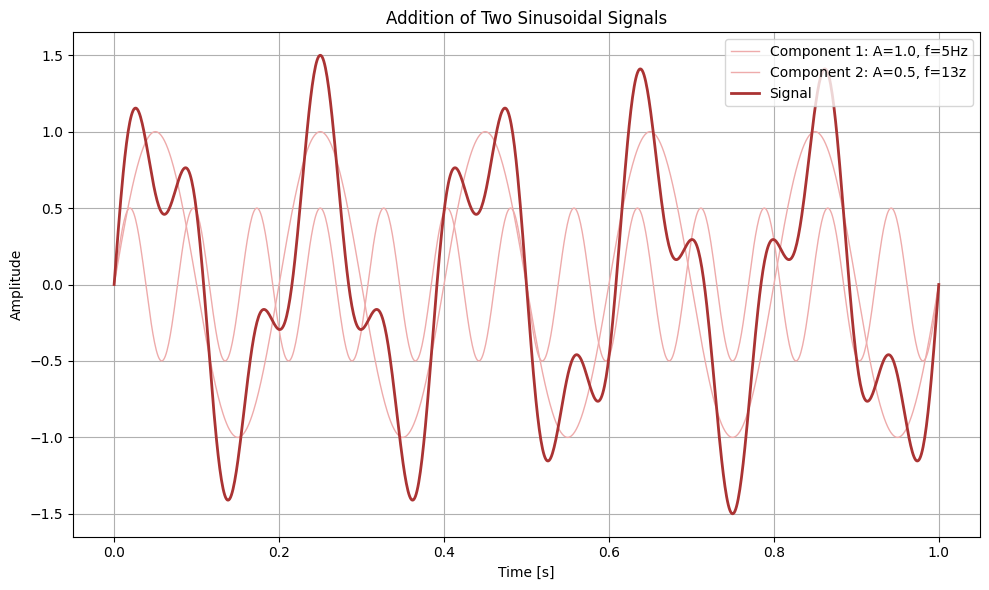

In [2]:
import numpy as np
import matplotlib.pyplot as plt

signal_color = "#aa3333"
component_color = "#eeabab"

# Time axis
t = np.linspace(0, 1, 1000)  # 1 second sampled at 1000 points

#
# The frequency domain for the function we want to represent in time domain
#
A1, f1 = 1.0, 5   # Amplitude and frequency of first sine wave
A2, f2 = 0.5, 13  # Amplitude and frequency of second sine wave

y1 = A1 * np.sin(2 * np.pi * f1 * t)
y2 = A2 * np.sin(2 * np.pi * f2 * t)
y_sum = y1 + y2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, y1, label=f'Component 1: A={A1}, f={f1}Hz', linewidth=1, color=component_color)
plt.plot(t, y2, label=f'Component 2: A={A2}, f={f2}z', linewidth=1, color=component_color)
plt.plot(t, y_sum, label='Signal', linewidth=2, color=signal_color)
plt.title('Addition of Two Sinusoidal Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
#!pip install -q numpy scipy
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio

# Parameters
duration = 5.0
sample_rate = 10000 # 44100 is CD quality; not needed here
f1 = 500.0
f2 = 500.5
a1 = 0.5
a2 = 1.0

t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
signal1 = a1 * np.sin(2 * np.pi * f1 * t)
signal2 = a2 * np.sin(2 * np.pi * f2 * t)

combined_signal = signal1 + signal2
combined_signal /= np.max(np.abs(combined_signal))  # Normalize

# Convert to 16-bit PCM for WAV format
pcm_signal = np.int16(combined_signal * 32767)
write("combined.wav", sample_rate, pcm_signal)

# Playback in notebook (browser-based)
Audio("combined.wav")

In [4]:
# Take the previous signal and sample it randomly. What does
# it sound like?
# 
# # Fragmentation parameters
fragment_duration = 0.01  # in seconds
fragment_samples = int(fragment_duration * sample_rate)
num_fragments = int(len(combined_signal) / fragment_samples)

# Randomly select and stitch fragments
fragments = []
for _ in range(num_fragments):
    start = np.random.randint(0, len(combined_signal) - fragment_samples)
    fragment = combined_signal[start:start + fragment_samples]
    fragments.append(fragment)

fragmented_signal = np.concatenate(fragments)
fragmented_signal /= np.max(np.abs(fragmented_signal))  # Normalize again

# Convert to 16-bit PCM and write to file
pcm_fragmented = np.int16(fragmented_signal * 32767)
write("fragmented.wav", sample_rate, pcm_fragmented)

# Playback
Audio("fragmented.wav")


 ---

## DFT: aquire some data

The code below simulates a corrupted signal. The signal is imperfect but it looks periodic and squarish. We do not know its exact form but we can visualize its points.

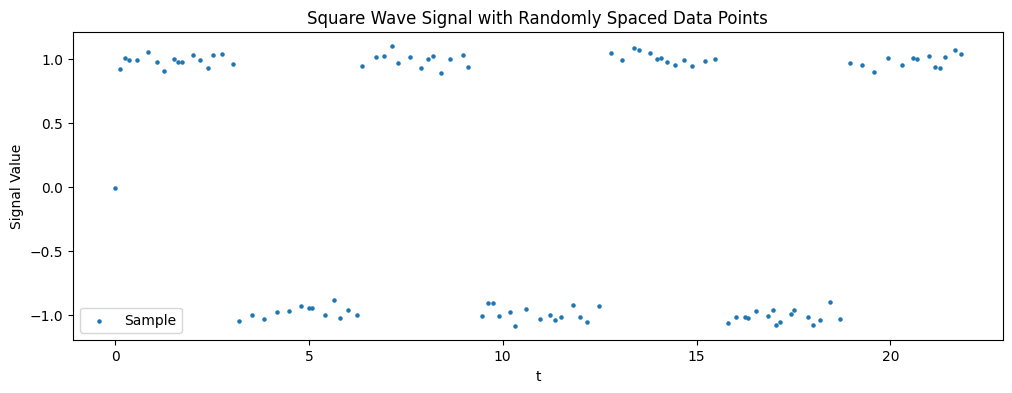

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_points = 100  # Total number of data points
cycles = 3.5  # Desired average number of square wave cycles
# Calculate the ideal total span of t
ideal_total = 2 * np.pi * cycles
# Compute the ideal spacing if t were evenly spaced
ideal_spacing = ideal_total / num_points
# Generate random spacings around the ideal spacing
# Here we allow the spacing to vary by ±66%
random_spacings = np.random.uniform(0.33 * ideal_spacing, 1.66 * ideal_spacing, num_points)
# Create t as the cumulative sum of the random spacings
t = np.cumsum(random_spacings)
t -= t[0]  # Ensure starting at 0
# Create a square wave signal using the sign of a sine wave evaluated at x
square_wave = np.sign(np.sin(t))
# Add randomness: Gaussian noise with a standard deviation of 0.05
noise = np.random.normal(scale=0.05, size=num_points)
signal = square_wave + noise
# Convert the signal to a list
signal_list = signal.tolist()
# Visualize the generated signal
plt.figure(figsize=(12, 4))
plt.scatter(t, signal, label="Sample", marker = 'o', s=5)
plt.title("Square Wave Signal with Randomly Spaced Data Points")
plt.xlabel("t"); plt.ylabel("Signal Value")
plt.legend(); plt.show()

---

## DFT: map the data to the frequency domain

If the data earlier are indeed periodic, what are the frequencies and amplitudes of their components? That's precicely what the DFT delivers. The code below uses the Fourier transform functions from `numpy`. We'll write our out DFT soon, but for now, the idea is to show how the process works.

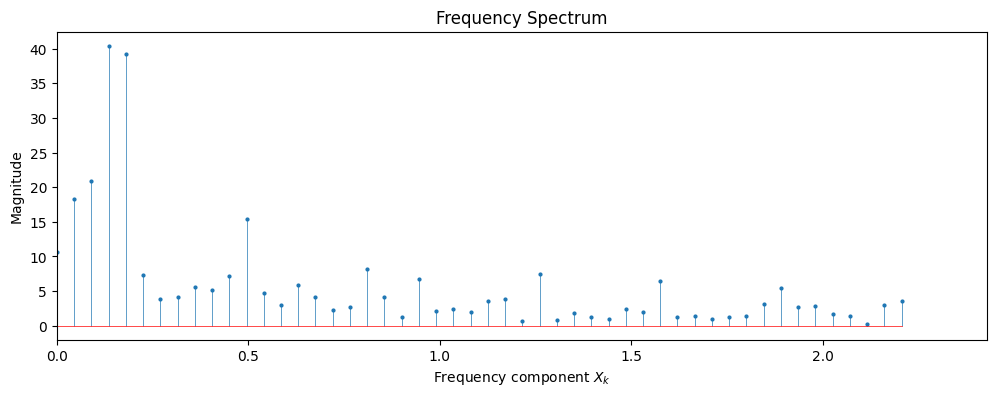

In [6]:
# Assuming signal_list is already defined
signal_array = np.array(signal_list)
# Compute the Discrete Fourier Transform (DFT)
dft_signal = np.fft.fft(signal_array)
# Re-create x values to determine the sampling period
num_points = len(signal_list)
cycles = 3.5
t = np.linspace(0, 2 * np.pi * cycles, num_points)
T = t[1] - t[0] # Assumed dt
# Compute frequency bins
freq = np.fft.fftfreq(num_points, d=T)
# Plot the magnitude spectrum using stem plot without use_line_collection
plt.figure(figsize=(12, 4))
markerline, stemlines, baseline = plt.stem(freq, np.abs(dft_signal))
plt.setp(baseline, 'color', 'r', 'linewidth', 0.5)
plt.setp(markerline, markersize=2)
plt.setp(stemlines, linewidth=0.5)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency component $X_k$")
plt.ylabel("Magnitude")
plt.xlim(left=0) # plt.xlim(-2.5, 2.5)  +/- limits show conjugate spectrum
plt.show()

---

## DFT: reconstruct the signal

Each $F_k$ in the DFT corresponds to a sinusoidal signal with a specific frequency and magnitude (which is proportional to its amplitude). Using this information we can produce some or all of the signals represented in the graph above. Then we add them together. Their sum approximates the signal we wish to reconstruct and analyze. The more components we add (in line 25 below) the better the approximation.

<>:57: SyntaxWarning: invalid escape sequence '\c'
<>:57: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pp/jgd_v11j76lc48n0bcz9pmlw0000gn/T/ipykernel_52460/4000501044.py:57: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Signal $\chi(t)$")


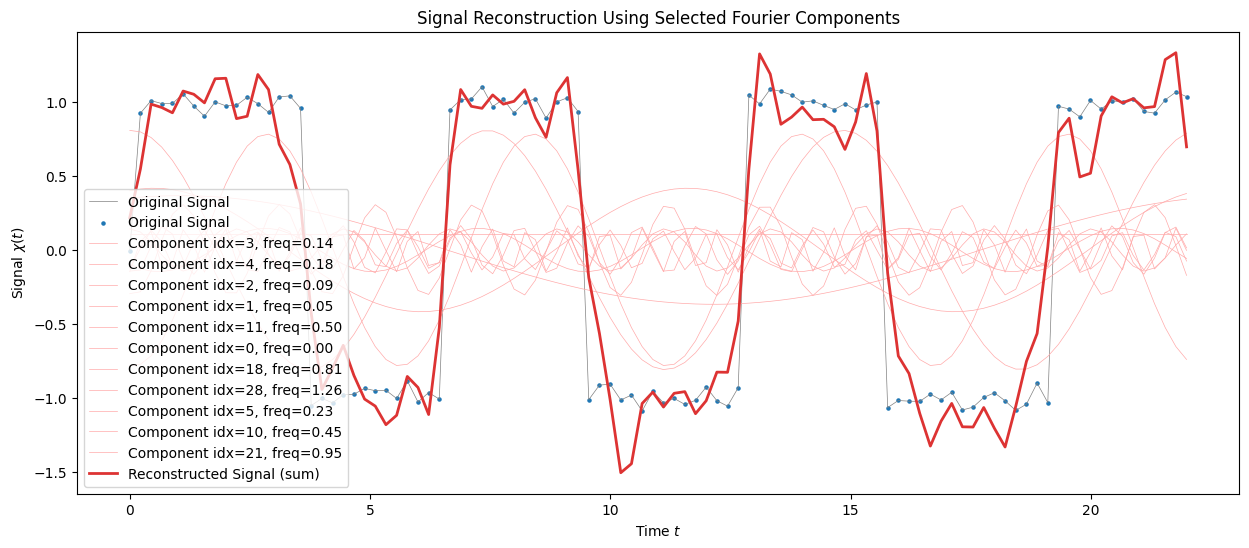

In [7]:
# Assume signal_list is already defined
signal_array = np.array(signal_list)
num_points = len(signal_array)
cycles = 3.5
# Re-create the x-values used to generate the signal
t = np.linspace(0, 2 * np.pi * cycles, num_points)
T = t[1] - t[0]
# Compute the DFT of the signal
dft_signal = np.fft.fft(signal_array)
# Get the frequency bins (frequencies in cycles per unit x)
freq = np.fft.fftfreq(num_points, d=T)
# For a real signal, the FFT is symmetric.
# We'll work only with the nonnegative frequency components:
pos_indices = np.arange(0, num_points//2 + 1)
# Get the magnitudes for these components:
magnitudes = np.abs(dft_signal[pos_indices])
# Sort indices by magnitude (largest first)
indices_sorted = pos_indices[np.argsort(magnitudes)[::-1]]
#
# How many X_k components do we want to use? Start with 0:0 -- just the first
# component; it's just a sine. Add components and try again, for example [0:3]
# then [0:5] then [0:11]. The more components we add the more faithful the
# reconstruction of the signal.
#                                _____ <<<<<<<<<<<<<< TRY OUT !
selected_indices = indices_sorted[0:11] # <=========== TRY OUT ! * * * * * * * *
# Initialize arrays to store individual sinusoids and the reconstructed signal
reconstructed = np.zeros_like(t)
sinusoids = {}
# Reconstruct each component:
# For a real signal, the inverse FFT tells us that each non-DC component
# contributes as: 2|X[k]|/N * cos(2*pi*freq[k]*x + phase)
# (DC and Nyquist components are not doubled)
for idx in selected_indices:
    comp = dft_signal[idx]
    phase = np.angle(comp)
    # Scale amplitude appropriately:
    if idx == 0 or (num_points % 2 == 0 and idx == num_points//2):
        amplitude = np.abs(comp) / num_points
    else:
        amplitude = 2 * np.abs(comp) / num_points
    # Compute the sinusoidal component:
    sinusoid = amplitude * np.cos(2 * np.pi * freq[idx] * t + phase)
    sinusoids[idx] = sinusoid
    # Sum this component into the reconstructed signal:
    reconstructed += sinusoid

# Plot the original signal, the individual sinusoidal components, and the reconstruction
plt.figure(figsize=(15, 6))
plt.plot(t, signal_array, label="Original Signal", color='grey', linewidth=0.5)
plt.scatter(t, signal, label="Original Signal", marker = 'o', s=5)
for i, idx in enumerate(selected_indices):
    plt.plot(t, sinusoids[idx],
             label=f"Component idx={idx}, freq={freq[idx]:.2f}",linewidth=0.5,
             color='#ffaaaa', linestyle='-') # colors[i % len(colors)]
plt.plot(t, reconstructed, label="Reconstructed Signal (sum)", color='#DD3333', linewidth=2)
plt.xlabel("Time $t$")
plt.ylabel("Signal $\chi(t)$")
plt.title("Signal Reconstruction Using Selected Fourier Components")
plt.legend()
plt.show()

---
# Image processing demo
---

In [ ]:

#!pip install numpy
#!pip install matplotlib
#!pip install opencv-python

import numpy as np
import matplotlib.pyplot as plt
import cv2 # computer vision module
from google.colab import files
from io import BytesIO # stream tools
from PIL import Image # python imaging library

ModuleNotFoundError: No module named 'google'

In [9]:
# Upload image and perform the FFT. Keep this code separate to avoid reloading
# the image gile every time we change the filtering characteristics later in the
# program.

# Try: https://www.som.com/wp-content/uploads/2017/10/Sears_00012_large-1633644098-scaled.jpg
uploaded = files.upload()

# Process the image file to convert to grayscale, then an array of values.
image_path = list(uploaded.keys())[0]
img = Image.open(BytesIO(uploaded[image_path])).convert('L')
img_array = np.array(img)

# Compute FFT
fft_result = np.fft.fft2(img_array)
# Shift low freq components to center for better viewing
fft_shifted = np.fft.fftshift(fft_result)


# Get image dimensions and report them
h, w = fft_shifted.shape

print(f'Your FFT is {w}x{h} pixels (WxH)')
print(f'Center is at {w//2}x{h//2}')
print(f'The largest mask you can apply at the center is {w//2}x{h//2}')
print(f'Widest top half mask: {w}x{h//2} @ 0,0')

NameError: name 'files' is not defined